In [ ]:
import torch
import sklearn
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [ ]:
df=pd.read_csv("/content/drive/My Drive/IA/diabetes.csv") #df stands for "dataframe"
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


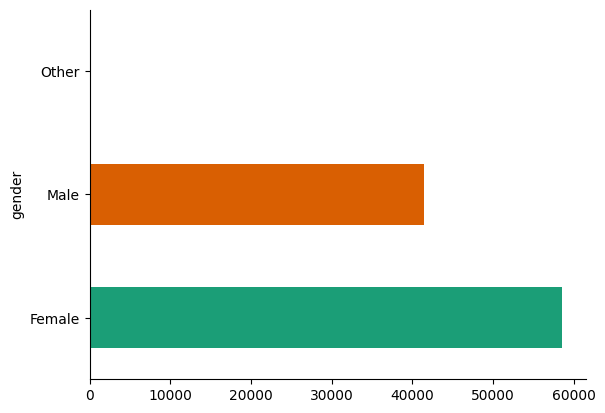

In [ ]:
# @title gender

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.info()
df.describe()
missing_values = df.isnull().sum()
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [ ]:
df.gender.value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [ ]:
#we discard the gender=other rows, as it doesen't have enough data to train the model (gender_other predictions may have been too inacurate)
df = df[df['gender'] != 'Other']
df.gender.value_counts()

,count
gender,
Female,58552
Male,41430


In [ ]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
#data preprocessing: changing unfitting data values ('gender' and 'smoking_history' columns [strings] to numbers)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['smoking_history_encoded'] = le.fit_transform(df['smoking_history'])#0=no info, 1=current smoker, 2=ever , 3=former, 4=never
df['gender_encoded'] = le.fit_transform(df['gender'])#male=1 female=0

df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_encoded,gender_encoded
0,Female,80.0,0,1,never,25.19,6.6,140,0,4,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0,0
2,Male,28.0,0,0,never,27.32,5.7,158,0,4,1
3,Female,36.0,0,0,current,23.45,5.0,155,0,1,0
4,Male,76.0,1,1,current,20.14,4.8,155,0,1,1


In [ ]:
#create a torch tensor for the training values (x) and y for target predictions
numerical_features = ['age', 'hypertension', 'heart_disease', 'smoking_history_encoded', 'HbA1c_level', 'blood_glucose_level', 'gender_encoded']
X = torch.tensor(df[numerical_features].values, dtype=torch.float)
y = torch.tensor(df['diabetes'].values, dtype=torch.float).view(-1, 1)
#Scale numerical features: scale numerical features to have zero mean and unit variance. This helps the neural network converge faster and perform better. standardization or min-max scaling. For example:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(df[['bmi', 'HbA1c_level', 'blood_glucose_level']])



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
#create the neural network
# set a random seed - do not modify
torch.manual_seed(42)

# Define the model using nn.Sequential
model = nn.Sequential(
    nn.Linear(7, 64),  # Input layer
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid(), # Output layer
)
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
# MSE loss function + optimizer
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2400
for epoch in range(num_epochs):
    predictions = model(X_train)
    MSE = loss(predictions, y_train)
    MSE.backward()
    optimizer.step()
    optimizer.zero_grad()
    # keep track of the loss during training
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], MSE Loss: {MSE.item()}')
#save the neural network
model.cpu()
torch.save(model, 'MSEmodel.pth')

Epoch [100/2400], MSE Loss: 0.08419385552406311
Epoch [200/2400], MSE Loss: 0.08416211605072021
Epoch [300/2400], MSE Loss: 0.0840853601694107
Epoch [400/2400], MSE Loss: 0.0839284360408783
Epoch [500/2400], MSE Loss: 0.08331356197595596
Epoch [600/2400], MSE Loss: 0.08159489929676056
Epoch [700/2400], MSE Loss: 0.0698428824543953
Epoch [800/2400], MSE Loss: 0.0540420264005661
Epoch [900/2400], MSE Loss: 0.043503113090991974
Epoch [1000/2400], MSE Loss: 0.03712132200598717
Epoch [1100/2400], MSE Loss: 0.08412611484527588
Epoch [1200/2400], MSE Loss: 0.08417277783155441
Epoch [1300/2400], MSE Loss: 0.08417277783155441
Epoch [1400/2400], MSE Loss: 0.08417277783155441
Epoch [1500/2400], MSE Loss: 0.08417277783155441
Epoch [1600/2400], MSE Loss: 0.08417277783155441
Epoch [1700/2400], MSE Loss: 0.08417277783155441
Epoch [1800/2400], MSE Loss: 0.08417277783155441
Epoch [1900/2400], MSE Loss: 0.08417277783155441
Epoch [2000/2400], MSE Loss: 0.08417277783155441
Epoch [2100/2400], MSE Loss: 0.0

In [ ]:
#evaluate the neural network
loaded_model = torch.load('MSEmodel.pth')

loaded_model.eval()
with torch.no_grad():
    predictions = loaded_model(X_test)
    test_MSE = loss(predictions, y_test)

# show output
print('Test MSE is ' + str(test_MSE.item()))
print('Test Root MSE is ' + str(test_MSE.item()**(1/2)))

RuntimeError: all elements of input should be between 0 and 1

In [ ]:
#neural net tests
#create the neural network
# set a random seed - do not modify
# Define the model using nn.Sequential
model = nn.Sequential(
    nn.Linear(7, 64),  # Input layer
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),  # Output layer with a single neuron
    nn.Sigmoid()
)
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
# BCE loss function + optimizer
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1800
for epoch in range(num_epochs):
    predictions = model(X_train)
    BCE = loss(predictions, y_train.view(-1, 1))  # Ensure target shape matches output
    BCE.backward()  # Backpropagate using BCE loss
    optimizer.step()
    optimizer.zero_grad()
    # keep track of the loss during training
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], BCE Loss: {BCE.item()}')

# Save the neural network
model.cpu()
torch.save(model, 'BCEmodel.pth')


Epoch [100/1800], BCE Loss: 0.3382514417171478
Epoch [200/1800], BCE Loss: 0.28250667452812195
Epoch [300/1800], BCE Loss: 0.23570440709590912
Epoch [400/1800], BCE Loss: 0.19546367228031158
Epoch [500/1800], BCE Loss: 0.16350220143795013
Epoch [600/1800], BCE Loss: 0.15178701281547546
Epoch [700/1800], BCE Loss: 0.1398983746767044
Epoch [800/1800], BCE Loss: 0.13198621571063995
Epoch [900/1800], BCE Loss: 0.1262366622686386
Epoch [1000/1800], BCE Loss: 0.1387343853712082
Epoch [1100/1800], BCE Loss: 0.12024786323308945
Epoch [1200/1800], BCE Loss: 0.11943244934082031
Epoch [1300/1800], BCE Loss: 0.11973212659358978
Epoch [1400/1800], BCE Loss: 0.11714088171720505
Epoch [1500/1800], BCE Loss: 0.12301677465438843
Epoch [1600/1800], BCE Loss: 0.11553962528705597
Epoch [1700/1800], BCE Loss: 0.11867301911115646
Epoch [1800/1800], BCE Loss: 0.13707906007766724


In [ ]:
#Optional lading of previous model
loaded_model = torch.load('model.pth')

In [ ]:
#evaluate the bce neural net
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
lmodel=torch.load('BCEmodel.pth')
# Make predictions on the test set
predictions = model(X_test)
predicted_labels = (predictions > 0.5).float()  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test.detach().numpy(), predicted_labels.detach().numpy())
precision = precision_score(y_test.detach().numpy(), predicted_labels.detach().numpy())
recall = recall_score(y_test.detach().numpy(), predicted_labels.detach().numpy())
f1 = f1_score(y_test.detach().numpy(), predicted_labels.detach().numpy())
roc_auc = roc_auc_score(y_test.detach().numpy(), predictions.detach().numpy())
conf_matrix = confusion_matrix(y_test.detach().numpy(), predicted_labels.detach().numpy())

# Print or visualize the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')

Accuracy: 0.9592932155359226
Precision: 0.8505050505050505
Recall: 0.645458029896512
F1-score: 0.7339289605578557
ROC-AUC: 0.9612270380573713


#Using BCE
1800 epochs: Test MSE is 0.11245240271091461
Test Root MSE is 0.33533923526917425

more epochs than that = overfitting

1200 epochs:Test MSE is 0.1172800287604332
Test Root MSE is 0.34246171867879366
#Using MSE
1800:Test MSE is 0.032713208347558975
Test Root MSE is 0.18086793067749454

1200:Test MSE is 0.038313280791044235
Test Root MSE is 0.1957377858029569

max suitable epochs:

2400: Test MSE is 0.03123602829873562
Test Root MSE is 0.17673717293975147


In [ ]:
#evaluate the neural network
loaded_model = torch.load('model.pth')

loaded_model.eval()
with torch.no_grad():
    predictions = loaded_model(X_test)
    test_MSE = loss(predictions, y_test)

# show output
print('Test MSE is ' + str(test_MSE.item()))
print('Test Root MSE is ' + str(test_MSE.item()**(1/2)))

FileNotFoundError: [Errno 2] No such file or directory: 'model.pth'

In [ ]:
#evaluate with bce

In [ ]:
# different evaluation method
from sklearn import metrics
print(metrics.classification_report(Y_test, predictions))

In [ ]:
#save the neural network
torch.save(model, 'model.pth')

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

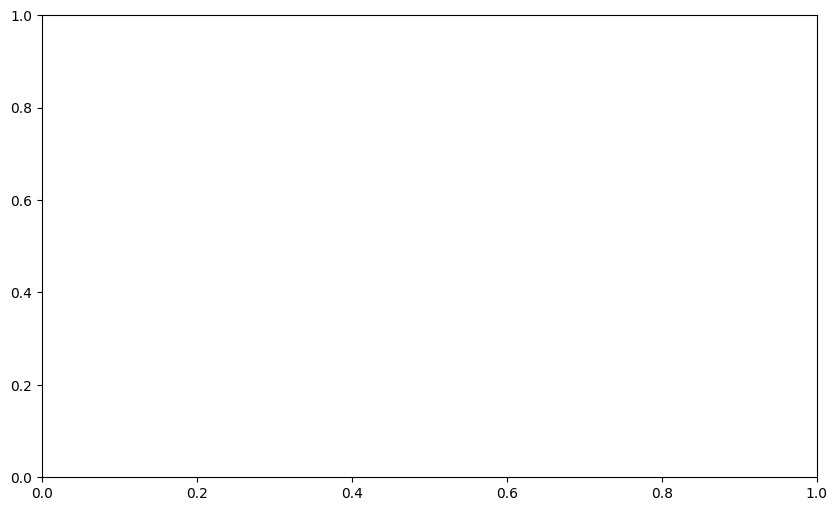

In [ ]:
#visualise training accuracy
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, label='Predictions', alpha=0.5, color='blue')

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray', linewidth=2,
         label="Actual Rent")
plt.legend()
plt.title('Diabetes dataset - Predictions vs Actual Values')
plt.show()